# Address Similarity Analysis Using TF-IDF Vectorization and Cosine Similarity

## Introduction
In this notebook, we demonstrate how to use TF-IDF vectorization and cosine similarity to identify the original forms of shortened addresses. This approach is useful in scenarios where addresses may have been truncated or altered or there is misspelling, and we need to find their closest matches from a reference dataset.

## Data Loading
We start by loading the original and modified addresses from JSON files.

In [3]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Load the original and modified addresses
with open('../data/original_all_addresses.json', 'r') as file:
    all_addresses = json.load(file)

with open('../data/modified_all_addresses.json', 'r') as file:
    modified_addresses = json.load(file)

# Convert the list of addresses to DataFrame
df_all_addresses = pd.DataFrame(all_addresses, columns=['address'])
df_modified_addresses = pd.DataFrame(modified_addresses, columns=['address'])

# Number of addresses
print(f"There are {len(df_all_addresses)} addresses in this dataset" )

There are 3220 addresses in this dataset


## TF-IDF Vectorization
TF-IDF (Term Frequency-Inverse Document Frequency) vectorization converts text data into numerical representations. Each address is transformed into a vector that reflects the importance of each word in the context of the entire dataset.

### Term Frequency (TF)

Term Frequency measures how frequently a term appears in a document. In our case, it measures how often a word appears in an address. To do this, we need to take two steps:

1. **Fit**: This step involves learning the vocabulary of all tokens (words) in the raw text documents. The vocabulary is a set of all distinct words in the corpus. In this case, the `fit` method looks at the entire list of addresses and identifies all the unique words.

2. **Transform**: This step transforms the text documents into a term frequency matrix. Each row in this matrix represents a document (an address), and each column represents a token (word) from the vocabulary. The values in the matrix are the counts of the tokens in each address. The result is typically a sparse matrix where most of the elements are zero. This is because most addresses will not contain most of the words.

The `fit_transform` method of `CountVectorizer` is a combined function that performs both the `fit` and `transform` functions and returns the term frequency matrix.

Let's first try it on a small number of addresses for a better understanding of the result:

In [12]:
def display_sample_term_frequency_matrix(df, n_samples):

    top_addresses = df['address'].head(n_samples).tolist()
    
    # Initialize the Count Vectorizer
    count_vectorizer = CountVectorizer()
    
    # Fit and transform the addresses to get the term frequencies
    term_frequencies = count_vectorizer.fit_transform(top_addresses)
    tf_df = pd.DataFrame(term_frequencies.toarray(), columns=count_vectorizer.get_feature_names_out())
    
    # Add the address column to the DataFrame for better readability
    tf_df.insert(0, 'address', top_addresses)
    print(tf_df)
    
display_sample_term_frequency_matrix(df_all_addresses, 5)

                   address  150  1745  2721  560  6007  applegate  avenue  \
0  1745 T Street Southeast    0     1     0    0     0          0       0   
1      6007 Applegate Lane    0     0     0    0     1          1       0   
2       560 Penstock Drive    0     0     0    1     0          0       0   
3        150 Carter Street    1     0     0    0     0          0       0   
4      2721 Lindsay Avenue    0     0     1    0     0          0       1   

   carter  drive  lane  lindsay  penstock  southeast  street  
0       0      0     0        0         0          1       1  
1       0      0     1        0         0          0       0  
2       0      1     0        0         1          0       0  
3       1      0     0        0         0          0       1  
4       0      0     0        1         0          0       0  


Now lets apply that to the entire list of addresses:

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the Count Vectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the addresses to get the term frequencies
term_frequencies = count_vectorizer.fit_transform(df_all_addresses['address'])

# Create a DataFrame to display the term frequencies
# Each row is an address and each column is a unique word from all addresses and the value is the count of that word in that address
tf_df = pd.DataFrame(term_frequencies.toarray(), columns=count_vectorizer.get_feature_names_out())

print(f"Term frequesncies matrix shape: {tf_df.shape}")

Term frequesncies matrix shape: (3220, 4389)


### Inverse Document Frequency (IDF)

Inverse Document Frequency measures the importance of a term in the entire corpus. It reduces the weight of common terms and increases the weight of rare terms. Let's calculate the IDF for the terms in our address data.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)

# Fit the vectorizer to the address data
tfidf_vectorizer.fit(df_all_addresses['address'])

# Get the IDF values for each term
idf_values = tfidf_vectorizer.idf_

# Create a DataFrame to display the IDF values
idf_df = pd.DataFrame({'Term': tfidf_vectorizer.get_feature_names_out(), 'IDF': idf_values})

print("top most common words (Low IDF value):")
print(idf_df.sort_values(by='IDF', ascending=True).head(10))
print("top least common words (High IDF value):")
print(idf_df.sort_values(by='IDF', ascending=False).head(10))

top most common words (Low IDF value):
           Term       IDF
4101     street  2.395339
2910      drive  2.742393
2431     avenue  2.819780
3905       road  2.988402
4296       west  3.357135
3673      north  3.809589
3394       lane  3.895664
2798      court  3.924156
3680  northwest  4.179607
2927       east  4.202250
top least common words (High IDF value):
         Term     IDF
2194     8726  8.3843
3720  pafford  8.3843
2211     8848  8.3843
2212     8852  8.3843
2213     8886  8.3843
2214     88th  8.3843
3721  palermo  8.3843
2216      890  8.3843
2217     8915  8.3843
2218     8934  8.3843


### Combining TF and IDF to Get TF-IDF

TF-IDF is calculated by multiplying the Term Frequency (TF) of a term by its Inverse Document Frequency (IDF). This gives us a measure of the importance of a term in a specific document (address in this case) relative to the entire corpus. Let's calculate the TF-IDF values for a small sample of address data.

In [22]:
# Transform the addresses to get the TF-IDF values
tfidf_matrix = tfidf_vectorizer.transform(df_all_addresses['address'])

# Create a DataFrame to display the TF-IDF values
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head()

,10,100,10001,1001,1002,1004,1007,1008,101,1010,...,yerxa,yosemite,young,youngs,yucca,yule,zelda,zenith,zephyr,zion
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


as expected it is mostly zero. to have a better undrestanding of the efidf matrix, lets only look at the columns that exist in the top 5 addresses. another point to consider is that The CountVectorizer and TfidfVectorizer classes in scikit-learn have default parameters that ignore terms with a length of one character. This is done to remove common stopwords and single-character tokens that are not useful for analysis:

In [23]:
# Add the address column to the DataFrame for better readability
tfidf_df.insert(0, 'address', df_all_addresses['address'])

# Get the top 5 addresses
top_5_addresses = df_all_addresses['address'].head(5)

# Get the TF-IDF values for the top 5 addresses
top_5_tfidf_matrix = tfidf_vectorizer.transform(top_5_addresses)
top_5_tfidf_df = pd.DataFrame(top_5_tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Get the terms that exist in the top 5 addresses
non_zero_columns = top_5_tfidf_df.loc[:, (top_5_tfidf_df != 0).any(axis=0)].columns

# Filter the original TF-IDF DataFrame to include only these columns
filtered_tfidf_df = tfidf_df[['address'] + list(non_zero_columns)]

# Display the filtered DataFrame
print(filtered_tfidf_df.head())


                   address       150      1745      2721       560      6007  \
0  1745 T Street Southeast  0.000000  0.826431  0.000000  0.000000  0.000000   
1      6007 Applegate Lane  0.000000  0.000000  0.000000  0.000000  0.653357   
2       560 Penstock Drive  0.000000  0.000000  0.000000  0.688921  0.000000   
3        150 Carter Street  0.650487  0.000000  0.000000  0.000000  0.000000   
4      2721 Lindsay Avenue  0.000000  0.000000  0.687922  0.000000  0.000000   

   applegate   avenue    carter     drive      lane   lindsay  penstock  \
0   0.000000  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000   
1   0.686559  0.00000  0.000000  0.000000  0.319001  0.000000  0.000000   
2   0.000000  0.00000  0.000000  0.225337  0.000000  0.000000  0.688921   
3   0.000000  0.00000  0.730298  0.000000  0.000000  0.000000  0.000000   
4   0.000000  0.23136  0.000000  0.000000  0.000000  0.687922  0.000000   

   southeast    street  
0   0.511141  0.236106  
1   0.000000  0.00

### Visualizing TF-IDF Values

To better understand the importance of different terms in our address data, we can visualize the TF-IDF values. Here you can plot the TF-IDF scores for any address index.


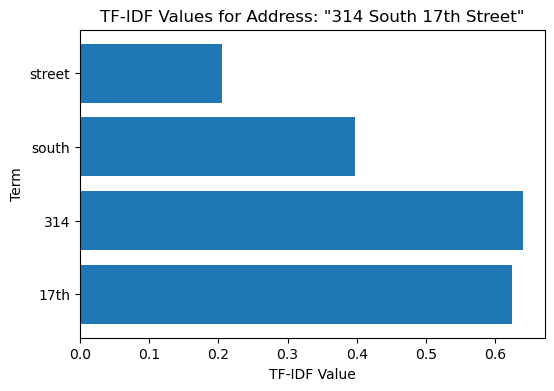

In [26]:
import matplotlib.pyplot as plt

# Select a sample address to visualize its TF-IDF values
sample_address_index = 15
sample_address = df_all_addresses['address'].iloc[sample_address_index]
sample_tfidf_values = tfidf_matrix[sample_address_index].toarray().flatten()

# Create a DataFrame for the sample TF-IDF values
sample_tfidf_df = pd.DataFrame({'Term': tfidf_vectorizer.get_feature_names_out(), 'TF-IDF': sample_tfidf_values})
sample_tfidf_df = sample_tfidf_df[sample_tfidf_df['TF-IDF'] > 0]  # Filter out zero TF-IDF values

# Plot the TF-IDF values
plt.figure(figsize=(6, 4))
plt.barh(sample_tfidf_df['Term'], sample_tfidf_df['TF-IDF'])
plt.xlabel('TF-IDF Value')
plt.ylabel('Term')
plt.title(f'TF-IDF Values for Address: "{sample_address}"')
plt.show()


### Applying TF-IDF Vectorization to Address Data

Once we have a detailed understanding of TF-IDF, we can apply this technique to our address data. The purpose of the previous TF-IDF code was to explain how the method works under the hood. For obtaining the results, the few lines of code below are sufficient to calculate the TF-IDF matrix for both the original addresses (training set) and the modified addresses (test set). The following steps illustrate how we initialize the TF-IDF Vectorizer, fit it to our original addresses, and transform both the original and modified addresses into TF-IDF matrices.

1. **Initialize the TF-IDF Vectorizer**:
   - We start by creating an instance of `TfidfVectorizer`. This object will be used to convert our text data into TF-IDF features.

2. **Fit and Transform the Original Addresses**:
   - The `fit_transform` method is applied to the original addresses (`df_all_addresses['address']`). This step will directly give us the TF-IDF matrix for the original address data.

3. **Transform the Modified Addresses**:
   - Using the already fitted vectorizer, we transform the modified addresses (`df_modified_addresses['address']`). This step uses the learned vocabulary and IDF to convert the modified addresses into a TF-IDF matrix. It is important to note that we don't fit the vectorizer on the modified addresses. In other words, we are not calculating the importance value of those terms that only exist in the modified version (test set) and consider it as zero. A TF-IDF value of zero means that the term does not contribute to the document vector in the transformed space. This neutrality ensures that new terms do not introduce any bias or noise into the similarity calculation. Essentially, the similarity is calculated based only on the shared vocabulary learned from the original data.

By performing these steps, we convert our textual address data into numerical TF-IDF representations. These representations can then be used for further analysis, such as comparing the similarity between original and modified addresses using cosine similarity.



In [7]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the addresses with TF-IDF Vectorizer
tfidf_all = vectorizer.fit_transform(df_all_addresses['address'])
tfidf_changed = vectorizer.transform(df_modified_addresses['address'])

### Cosine Similarity

Cosine similarity is a metric used to determine how similar two documents are, regardless of their size. It calculates the cosine of the angle between two vectors, which in our case, are the TF-IDF representations of the addresses. Here’s how it works:

1. **Cosine Similarity Calculation**:
   - Cosine similarity is calculated by dividing the dot product of the vectors by the product of their magnitudes. This results in a value between -1 and 1.
   - **Value of 1**: This indicates that the vectors are identical in direction, meaning the documents (addresses) are very similar.
   - **Value of 0**: This indicates that the vectors are orthogonal, meaning the documents have no terms in common and are completely different.
   - **Value of -1**: This indicates that the vectors are diametrically opposed, meaning they are completely dissimilar.

2. **Dot Product**:
   - The dot product of two vectors is the sum of the products of their corresponding elements. For example, for vectors A and B, the dot product is the sum of the products of their corresponding values.

3. **Magnitude**:
   - The magnitude (or length) of a vector is calculated as the square root of the sum of the squares of its elements. This gives a measure of the vector's length in multidimensional space.

Cosine similarity is particularly useful for text analysis because it is invariant to the length of the documents. This means that it focuses on the orientation (direction) of the vectors rather than their magnitude, making it ideal for comparing documents of different lengths.

By using cosine similarity, we can measure how similar the modified addresses are to the original addresses based on their TF-IDF representations. This helps in identifying the most similar original address for each modified address, providing insights into how the addresses have changed.

In [8]:
# Calculate cosine similarity between the shortened and original addresses
cosine_similarities = cosine_similarity(tfidf_changed, tfidf_all)

## Matching Shortened Addresses to Original Addresses
We define a function to find the most similar original address for each shortened address based on the highest cosine similarity.

In [9]:
# Function to find the most similar original address for each shortened address
def find_most_similar_address(similarities, original_addresses):
    most_similar = []
    for i in range(similarities.shape[0]):
        most_similar_idx = similarities[i].argmax()
        most_similar.append(original_addresses[most_similar_idx])
    return most_similar

# Find the most similar original addresses
most_similar_addresses = find_most_similar_address(cosine_similarities, df_all_addresses['address'])

## Results
We compare the shortened addresses with their most similar original addresses. Only those addresses that were modified (shortened) are included in the results.

In [10]:
# Create a DataFrame to show the results
df_results = pd.DataFrame({
    'Shortened Address': df_modified_addresses['address'],
    'Most Similar Original Address': most_similar_addresses
})

# Filter out the addresses that were not changed
df_filtered_results = df_results[df_results['Shortened Address'] != df_results['Most Similar Original Address']]

df_filtered_results.to_json('../data/similar_addresses.json', orient='records', lines=True)

# Display the results
df_filtered_results.head()

#Todo: add an accuracy measure

,Shortened Address,Most Similar Original Address
17,5461 Wst Shades Vlley Drve,5461 West Shades Valley Drive
21,3729 East Mission Bulevard,3729 East Mission Boulevard
38,802 Madisn Stret Northwest,802 Madison Street Northwest
39,2811 Bttery Plac Northwest,2811 Battery Place Northwest
50,1508 Msschstts vn Sotheast,1508 Massachusetts Avenue Southeast


## Visualization
To better understand the distribution of address lengths and the impact of shortening, we plot histograms of the lengths of the original and modified addresses.

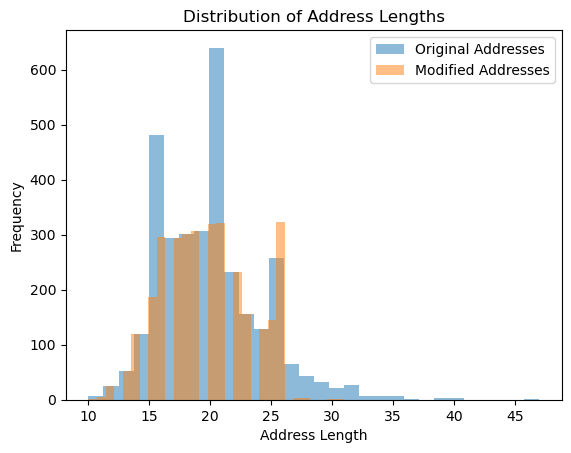

In [12]:
import matplotlib.pyplot as plt

# Plot histogram of original address lengths
df_all_addresses['length'] = df_all_addresses['address'].apply(len)
plt.hist(df_all_addresses['length'], bins=30, alpha=0.5, label='Original Addresses')

# Plot histogram of modified address lengths
df_modified_addresses['length'] = df_modified_addresses['address'].apply(len)
plt.hist(df_modified_addresses['length'], bins=30, alpha=0.5, label='Modified Addresses')

plt.xlabel('Address Length')
plt.ylabel('Frequency')
plt.title('Distribution of Address Lengths')
plt.legend()
plt.show()

## Accuracy Measure
Finally, we calculate an accuracy measure to evaluate how well the cosine similarity method matched the shortened addresses to their original forms.

In [13]:
#ToDo: Accuracy Measure

## Conclusion
In this notebook, we demonstrated how to use TF-IDF vectorization and cosine similarity to find the most similar original addresses for shortened addresses. This method can be useful in various data cleaning and preprocessing tasks where maintaining the integrity of textual data is crucial.